# Sequences, Time Series and Prediction in TensorFlow

### Notes from the Deeplearning.ai Specialization in Coursera, as taught by Andrew Ng and Laurence Muroney

### By Carlos Santillán

#### July 2020

# Week 1

## 1.1. Sequences and Prediction

Time series are everywhere:

- Weather forecasts

- Stock market data

**What are Time Series?**

- We can consider them as points of data in a given time with always the same size in time jump.

- They can be univariate or multivariate

    - Consider for example the movement of a car, we can look at it as a combination of lattitude and longitude coordinates, while accelaration may change the size of the time step

### 1.1.2. Machine Learning applied to Time Series

- The first and most obvious, is to forecast

- We can also project back into the past (**imputation**)

- Detect anomalies, for example website logs.

- Spot patterns, for example sound waves

### 1.1.3. Common patterns in time series

1. First we have **trend**

2. **Seasonality** is when a pattern repeats over a period of time

3. They can have a combination of this factors

4. Then we have **white noise**, which is basically random behavior

5. We say we have an **Autocorrelated** Time Series when it is correlated with itself, usually correlated with a lag of the original series.

Usually Time Series will have Trend + Seasonality + Autocorrelation + Noise


We will also deal with **Non-stationary** Time Series, which would basically means that it´s behavior has changed over time.

   - With this type of time Series the usual procedure is to train only on the most recent behavior, but this may go against the principle of "the more data we have, the better"
    
   - Taking all the Time Series is something that we will only be able to do with a **stationary** Time Series

### 1.1.4. Introduction to Time Series in Python



Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    '''
    INPUT: time
    INPUT: series
    INPUT: format
    INPUT: start
    INPUT: end
    INPUT: label
    
    OUTPUT: plot of the Time Series
    '''
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

Trend & Seasonality

In [3]:
def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

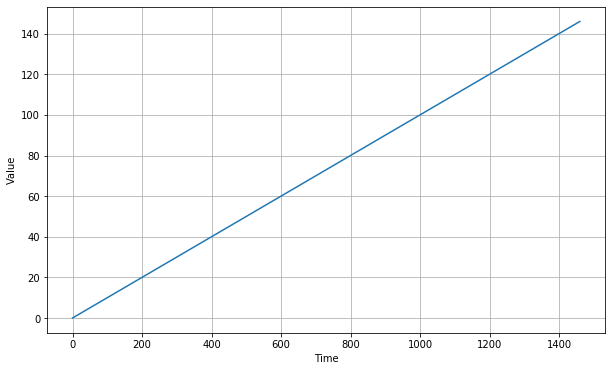

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a Time Series with a seasonal pattern:

In [5]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

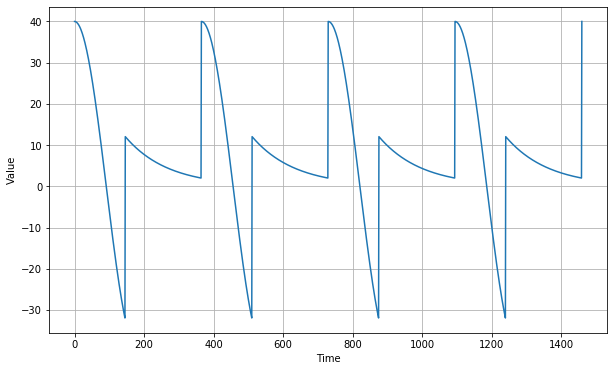

In [6]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a Time Series with both trend and seasonality:

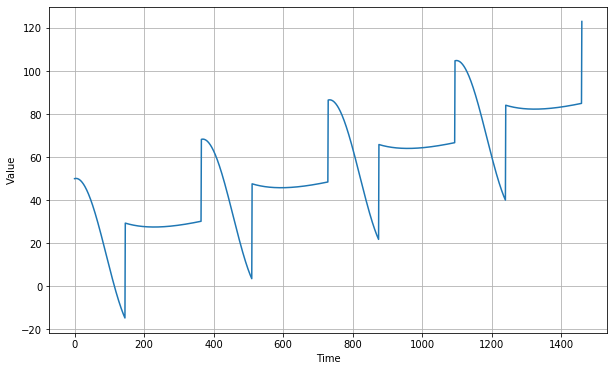

In [7]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [8]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

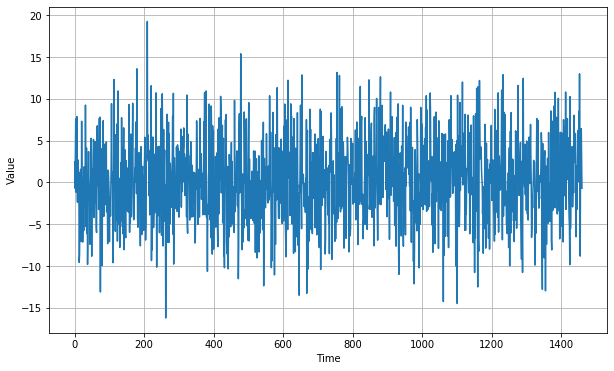

In [9]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add white noise to the time series:


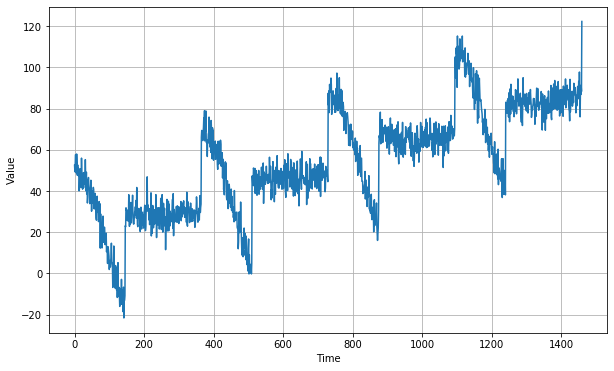

In [10]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). THe split will be at time step 1000.

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [15]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [13]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

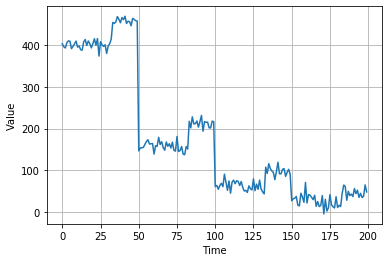

In [16]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

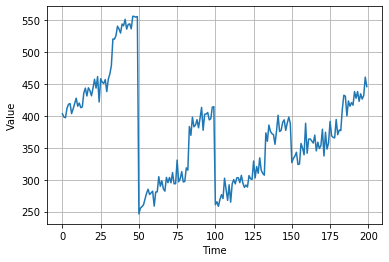

In [17]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

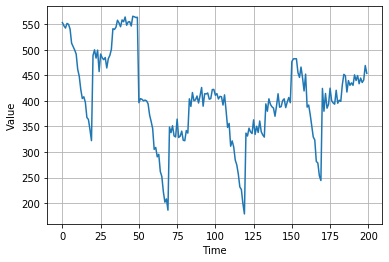

In [18]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

Let us add an event that drastically changes the behavior of the time series, think of a crash in the stock market:

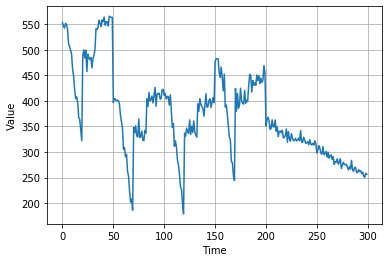

In [19]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [20]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

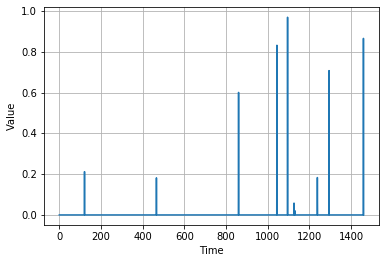

In [21]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [22]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

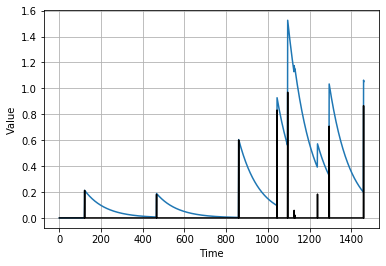

In [23]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

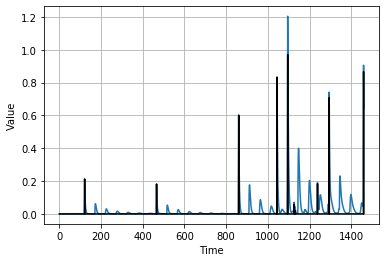

In [24]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

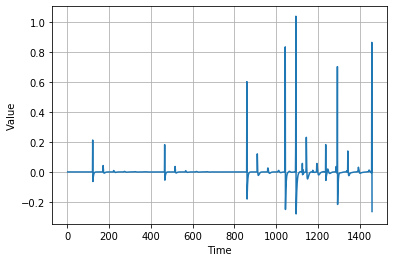

In [25]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

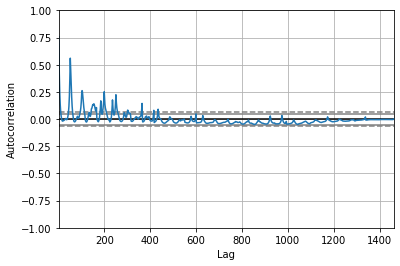

In [26]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [27]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


C:\Users\SANTICA4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Wed, 22 Jul 2020   AIC                          -4432.855
Time:                        21:39:26   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

### 1.1.5. Train, validation and test sets

Naive forecasting could be to take the last seen value and assume it will appear again.

Usually we want to partition the time series:

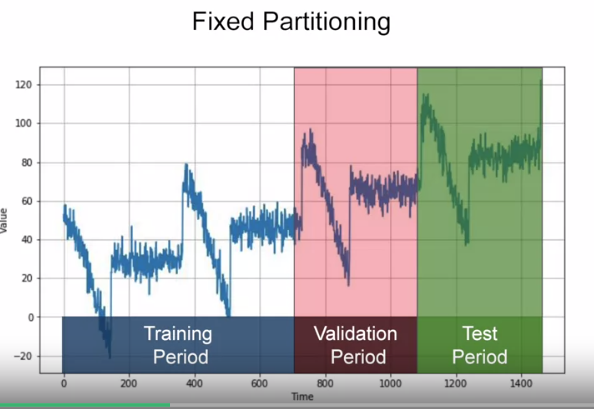

We often take the Test Period to be into the future, so we only split into Training Period and Validation Period.

We can also do some Roll-Forward Partitioning, which consists of training more data on every iteration.

### 1.1.6. Metrics for evaluating performance

- errors = forecast - actual

- mse = np.square(errors).mean()

- rmse = np.sqrt(mse)

- mae = np.abs(errors).mean()

- mape = np.abs(errors / x_valid).mean()

Most used is the MSE (Mean Squared Error) so that our errors do not cancel each other out.

By taking de RMSE we then return to the same scale of the errors.

MAE doesn´t penalize large errors as much as MSE does



### 1.1.7. Moving average and differencing

A common and very simple forecasting method is the Moving Average, this eliminates a lot of noise but doesn´t anticipate trend or seasonality.

To avoid this we need to remove the trend and seasonality from the Time Series by **differencing**

Before moving into Deep Learning always remember: **simple approaches often work the best**

### 1.1.8. Trailing vs. Centered Windows

To smooth past values we can use centered windows

### 1.1.9. Forecasting

Statistical forecasting should give us some form of baseline to see if we can improve it with Machine Learning Techniques